In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent[0]

'2017-08-23'

In [10]:
query_date = datetime.strptime(recent[0],'%Y-%m-%d')  - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23 00:00:00


In [11]:
#query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#print("Query Date: ", query_date)

precipitation = session.query(measurement.date, measurement.prcp).filter(measurement.date >= '2016-08-23').order_by(measurement.date).all()
precipitation 

precipitation_dict = {}

for date, value in precipitation:
    if date not in precipitation_dict:
        precipitation_dict[date] = []
    if value is not None:  # Exclude None values
        precipitation_dict[date].append(value)

precipitation_dict

{'2016-08-23': [0.0, 0.15, 0.05, 0.02, 1.79, 0.7],
 '2016-08-24': [0.08, 2.15, 2.28, 1.22, 2.15, 1.45],
 '2016-08-25': [0.08, 0.08, 0.0, 0.0, 0.21, 0.06, 0.11],
 '2016-08-26': [0.0, 0.03, 0.02, 0.04, 0.0, 0.01],
 '2016-08-27': [0.0, 0.18, 0.02, 0.0, 0.12],
 '2016-08-28': [0.01, 0.14, 0.14, 0.14, 0.6, 2.07],
 '2016-08-29': [0.0, 0.17, 0.04, 0.0, 0.35, 0.9],
 '2016-08-30': [0.0, 0.0, 0.02, 0.0, 0.0, 0.05],
 '2016-08-31': [0.13, 0.1, 0.25, 0.24, 2.46],
 '2016-09-01': [0.0, 0.0, 0.0, 0.02, 0.01],
 '2016-09-02': [0.0, 0.02, 0.19, 0.01, 0.03],
 '2016-09-03': [0.0, 0.07, 0.08, 0.12, 1.0],
 '2016-09-04': [0.03, 0.03, 0.74, 0.14, 0.44],
 '2016-09-05': [0.11, 0.02, 0.03, 0.18],
 '2016-09-06': [0.05, 0.04, 0.03, 0.11, 1.0],
 '2016-09-07': [0.05, 0.1, 0.23, 0.11, 0.16, 1.35],
 '2016-09-08': [0.0, 0.22, 0.01, 0.01, 0.07, 0.15],
 '2016-09-09': [0.03, 0.01, 0.29, 0.23, 0.16, 0.35],
 '2016-09-10': [0.0, 0.01, 0.14, 0.09, 1.16],
 '2016-09-11': [0.05, 0.18, 0.12, 0.3, 0.6],
 '2016-09-12': [0.0, 0.04, 0.

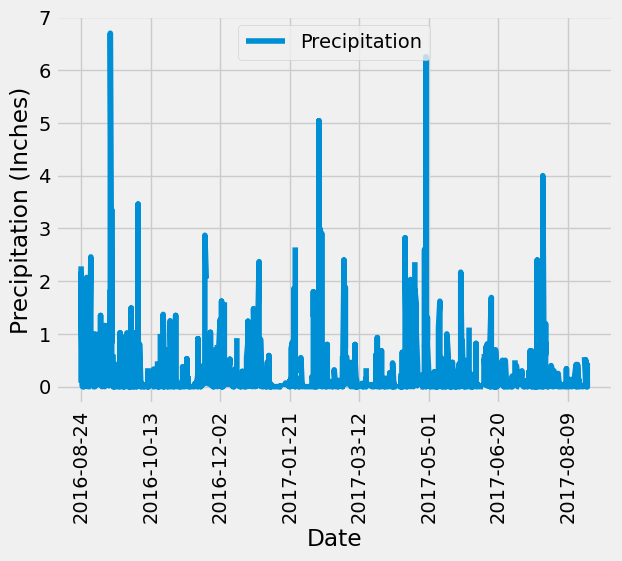

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
query = f"SELECT date, prcp FROM measurement WHERE date > '2016-08-23' ORDER BY date"

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.read_sql(query, engine)
precipitation_df.columns=['date','precipitation']
# Sort the dataframe by date
precipitation_df.sort_values(by='date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
ax.plot(precipitation_df['date'], precipitation_df['precipitation'], label='Precipitation')
ax.set(xlabel="Date", ylabel="Precipitation (Inches)")
ax.xaxis.set_major_locator(plt.MaxNLocator(9))
ax.legend(loc='upper center')
plt.xticks(rotation=90)

plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_df = precipitation_df.agg({'precipitation': ['count', 'mean', 'std', 'min',
                                                    lambda x: x.quantile(0.25), 'median',
                                                    lambda x: x.quantile(0.75), 'max']})
summary_df.index = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
summary_df

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
query = 'SELECT COUNT(DISTINCT station) FROM station;'
session.query(func.count(measurement.station.distinct())).scalar()

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
activity = session.query(measurement.station, func.count(measurement.station)) \
    .group_by(measurement.station) \
    .order_by(func.count(measurement.station).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)) \
    .filter(measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

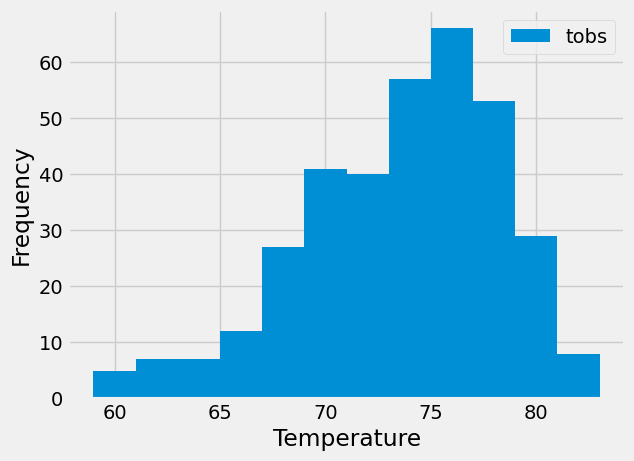

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_dist = session.query(measurement.tobs, func.count(measurement.tobs)).filter(measurement.date > query_date, measurement.station == 'USC00519281').group_by(measurement.tobs).all()
temp_dist_df = pd.DataFrame(temp_dist, columns=['Temperature', 'Count'])
plt.hist(temp_dist_df['Temperature'], weights=temp_dist_df['Count'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Experimentation for app.py

In [18]:
stations = session.query(station).all()

In [19]:

station_dict = {}

for station in stations:
    if station.station not in station_dict:
        station_dict[station.station] = []
        temp = [station.name, station.latitude, station.longitude, station.elevation]
        station_dict[station.station] = temp

station_dict

{'USC00519397': ['WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0],
 'USC00513117': ['KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6],
 'USC00514830': ['KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0],
 'USC00517948': ['PEARL CITY, HI US', 21.3934, -157.9751, 11.9],
 'USC00518838': ['UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6],
 'USC00519523': ['WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5],
 'USC00519281': ['WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9],
 'USC00511918': ['HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9],
 'USC00516128': ['MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4]}

In [21]:
#Query the dates and temperature observations of the most-active station for the previous year of data.

session.query(measurement.date, measurement.tobs).filter(measurement.date > query_date, measurement.station == 'USC00519281').order_by(measurement.date).all()

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

In [22]:
session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)) \
    .filter(measurement.date > '2016-08-24').all()

[(58.0, 87.0, 74.56949458483754)]

# Close Session

In [23]:
# Close Session
session.close()